# 📦 Importing Required Libraries

# - pandas: Data loading and manipulation
# - sklearn: Model training, evaluation, preprocessing
# - seaborn & matplotlib: Data visualization
# - KMeans, PCA: Clustering and dimensionality reduction for unsupervised analysis


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 📄 Load the Cleaned & Feature-Engineered Dataset (with Rainfall)

# - This dataset includes rainfall columns and engineered metrics.
# - It's prepared in the earlier steps of the pipeline (EDA + feature creation).

In [ ]:
df = pd.read_csv('cleaned_reservoir_dataset_with_rainfall.csv')
df.head()

NameError: name 'pd' is not defined

# 🧠 Rule-Based Drought Risk Categorization Function

# - Assigns drought severity levels based on:
#     → net flow (positive or negative)
#     → actual vs. normal rainfall
#     → storage percentage
# - Returns one of: Severe Risk, High Risk, Water Stress, Caution, No Risk

In [ ]:
def determine_drought_status(row):
    net_flow = row['net_flow']
    avg_rainfall = row['Avg_monthly_Rainfall']
    normal_rainfall = row['Normal Rainfall ']
    storage_level = row['storage_percent']

    if (net_flow < 0 or avg_rainfall < normal_rainfall) and storage_level < 20:
        return "Severe Risk"
    elif (net_flow < 0 or avg_rainfall < normal_rainfall) and 20 <= storage_level < 40:
        return "High Risk"
    elif (net_flow < 0 or avg_rainfall < normal_rainfall) and 40 <= storage_level < 70:
        return "Water Stress"
    elif (net_flow < 0 or avg_rainfall < normal_rainfall) and 70 <= storage_level < 90:
        return "Caution"
    elif (avg_rainfall > normal_rainfall) and storage_level > 100:
            return "Probable chances of Flood"
    else:
        return "No Risk"

# 🏷️ Apply the Risk Categorization to the Dataset

# - Creates a new column `drought_status` containing the risk labels from the function.

In [ ]:
df['drought_status'] = df.apply(determine_drought_status, axis=1)

# 🔢 Encode the Categorical Risk Labels to Numerical Labels

# - Uses LabelEncoder to convert text labels into integers
# - Required for model training

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['drought_label'] = label_encoder.fit_transform(df['drought_status'])

# 🎯 Select Features and Target Variable

# - `features`: Columns used as input for the model
# - `X`: Input data
# - `y`: Encoded drought risk category (target)

In [ ]:
features = [
    'level_in_feet_present', 'gross_storage', 'net_flow',
    'flow_ratio', 'net_flow_per_capacity',
    'Avg_monthly_Rainfall', 'Normal Rainfall ', 'storage_percent'
]
X = df[features]
y = df['drought_label']

# ✂️ Split Data into Training and Testing Sets

# - 80% for training, 20% for testing
# - `random_state=42` ensures reproducibility

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Train Random Forest Classifier

# - Fits a RandomForest model on the training data

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# 📊 Generate Classification Report as a Dictionary (for Plotting)

# - Evaluates predictions on test set
# - Outputs precision, recall, f1-score per class

In [ ]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# 🧾 Add Model Predictions to Full Dataset

# - Predicts for the entire dataset (`X`)
# - Adds numerical predictions and converts them back to category labels

In [ ]:
df['predicted_label'] = model.predict(X)
df['predicted_status'] = label_encoder.inverse_transform(df['predicted_label'])

# 💾 Save the Prediction Results to CSV

# - Stores the final dataset with predicted status labels for external use

In [ ]:
output_path = "reservoir_with_drought_predictions.csv"
df.to_csv(output_path, index=False)

# 📊 Correlation Matrix: Rainfall vs Storage Metrics

# - Analyzes linear relationships between key variables
# - Heatmap visualizes correlation strength and direction

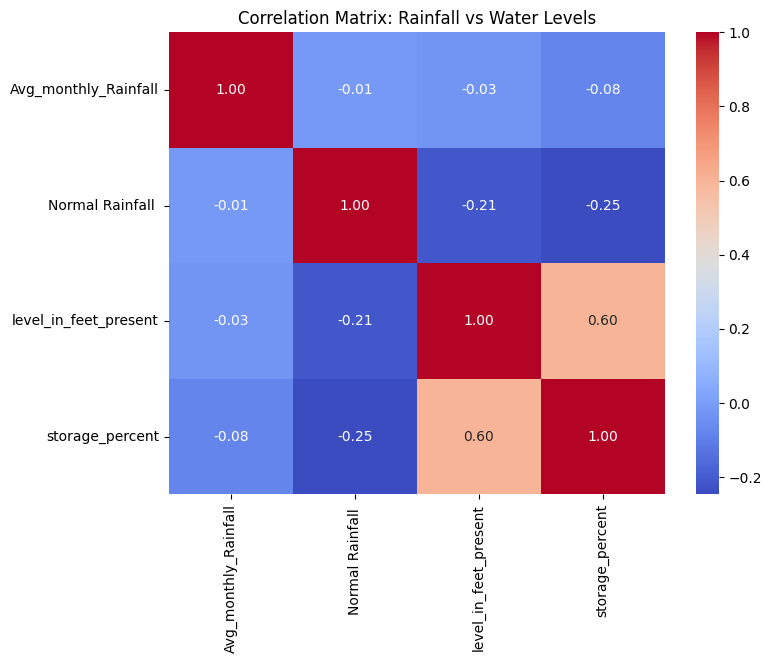

In [ ]:

# ===============================
# 📊 CORRELATION ANALYSIS SECTION
# ===============================
correlation_features = ['Avg_monthly_Rainfall', 'Normal Rainfall ', 'level_in_feet_present', 'storage_percent']
corr_matrix = df[correlation_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Rainfall vs Water Levels")
plt.show()

# 🔍 Clustering Reservoirs Based on Rainfall + Water Metrics

# - Standardizes features for clustering
# - Applies KMeans to group reservoirs into 4 clusters
# - Reduces dimensionality using PCA for visualization
# - Plots clusters in 2D using PCA components

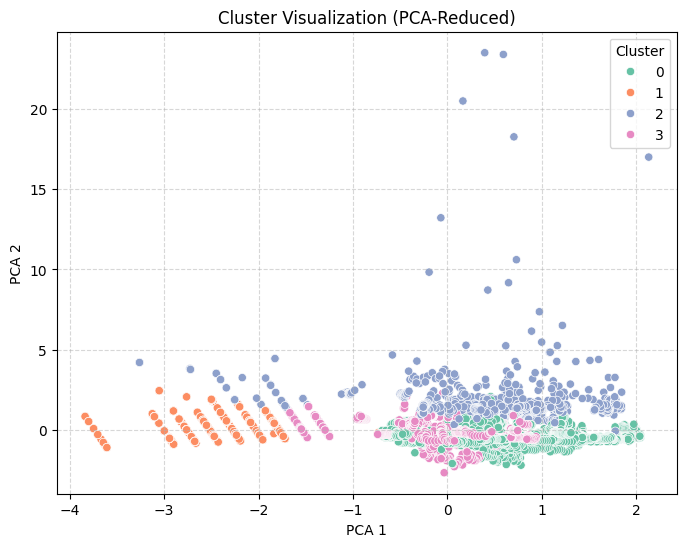

In [ ]:

# ===============================
# 🔍 CLUSTERING ANALYSIS SECTION
# ===============================

cluster_features = [
    'Avg_monthly_Rainfall', 'Normal Rainfall ',
    'level_in_feet_present', 'storage_percent', 'net_flow'
]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for 2D visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
df['pca1'], df['pca2'] = reduced[:, 0], reduced[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title("Cluster Visualization (PCA-Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# 📊 Bar Chart: Precision, Recall, F1 for Each Drought Risk Category

# - Uses report dictionary to extract metrics
# - Plots each metric (precision, recall, f1-score) for each risk label

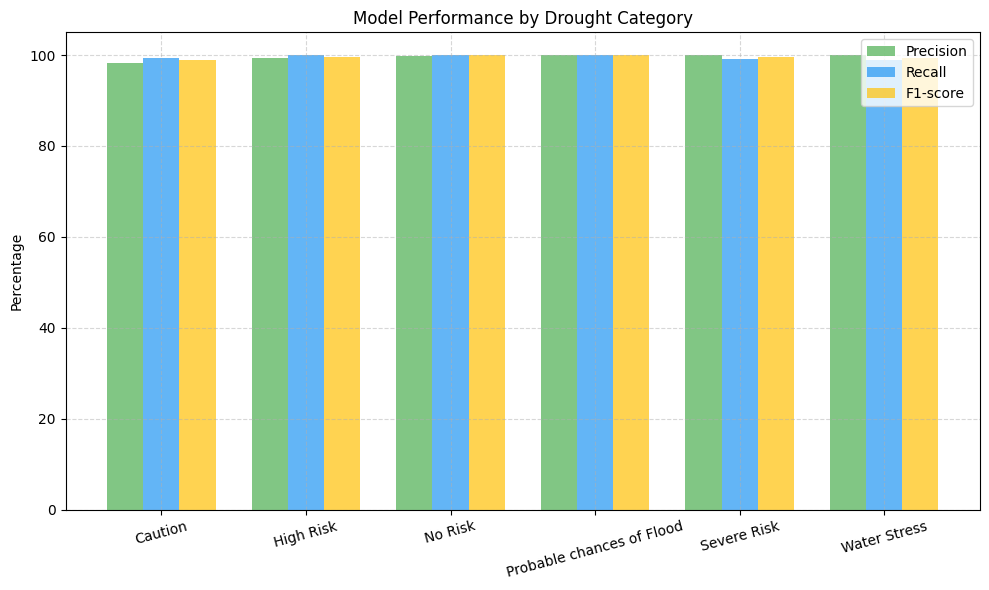

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
metrics = ['precision', 'recall', 'f1-score']
colors = ['#4CAF50', '#2196F3', '#FFC107']

plt.figure(figsize=(10, 6))
bar_width = 0.25
labels = label_encoder.classes_

for i, metric in enumerate(metrics):
    values = [report[label][metric] * 100 for label in labels]
    positions = [x + bar_width * i for x in range(len(labels))]
    plt.bar(positions, values, width=bar_width, label=metric.capitalize(), color=colors[i], alpha=0.7)

# X-axis setup
x_ticks = [r + bar_width for r in range(len(labels))]
plt.xticks(x_ticks, labels, rotation=15)
plt.ylabel("Percentage")
plt.title("Model Performance by Drought Category")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# ✅ Precision
# What it tells: Out of all the times the model predicted a certain drought status (e.g., "Severe Risk"), how often was it correct?

# Think of it as: How trustworthy are the model's predictions for each category?

# Example: If the model says "High Drought Risk" 100 times and it's correct 85 times, then precision is 85%.

# ✅ Recall
# What it tells: Out of all the actual cases of a drought status in the data, how many did the model successfully detect?

# Think of it as: How good is the model at catching all the real cases of a problem?

# Example: If there were 100 real "Severe Risk" cases, and the model correctly found 80 of them, recall is 80%.

# ✅ F1-Score
# What it tells: A balance between precision and recall.

# Think of it as: How good is the model overall in terms of both correctness and coverage?

# Example: If precision is high but recall is low (or vice versa), F1-score helps combine both into one useful score.

# 📋 Print Final Model Evaluation on Test Set
# - Re-displays classification report and confusion matrix
# - Useful for human interpretation or presentation


In [ ]:
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       171
           1       0.99      1.00      1.00       144
           2       1.00      1.00      1.00       709
           3       1.00      1.00      1.00         9
           4       1.00      0.99      1.00       117
           5       1.00      0.99      0.99       260

    accuracy                           1.00      1410
   macro avg       1.00      1.00      1.00      1410
weighted avg       1.00      1.00      1.00      1410

Confusion Matrix:
[[170   0   1   0   0   0]
 [  0 144   0   0   0   0]
 [  0   0 709   0   0   0]
 [  0   0   0   9   0   0]
 [  0   1   0   0 116   0]
 [  3   0   0   0   0 257]]
